In [1]:
# This solution is inpired by the following resources :
# - https://www.kaggle.com/code/amirhoseinsedaghati/digit-classification-using-cnn-0-9974-score
# - https://www.kaggle.com/code/skv1436/mnist-cnn-accuracy-0-99

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import math

## EDA

In [3]:
train_df = pd.read_csv('data/train.csv')
target_df = pd.read_csv('data/test.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [6]:
train_df.shape

(42000, 785)

In [7]:
train_image, train_label = train_df.iloc[:, 1:].values, train_df['label'].values

In [8]:
train_image = train_image.reshape((-1, 28, 28))
target_image = target_df.values.reshape((-1, 28, 28))

In [9]:
print(f'Shape of the training images: {train_image.shape}\nShape of the target images: {target_image.shape}')

Shape of the training images: (42000, 28, 28)
Shape of the target images: (28000, 28, 28)


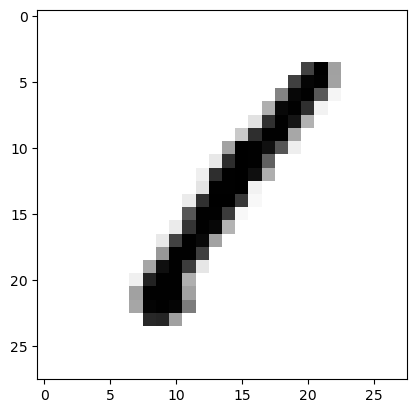

In [10]:
plt.imshow(train_image[0].reshape(28, 28), cmap=plt.cm.gray_r)

In [11]:
def display_images(images, labels=None, start=0, images_count=5):
    
    rows_count = math.ceil(images_count / 10)
    columns_count = min(10, images_count)
    counter = 0
    
    fig = plt.figure(figsize=(10, rows_count + 1))
    for i in range(images_count):
        index = start + i
        plt.subplot(rows_count, columns_count, i + 1)
        plt.imshow(images[index], cmap=plt.cm.gray_r);
        plt.axis('off');
        plt.title(f'{labels[index]}');

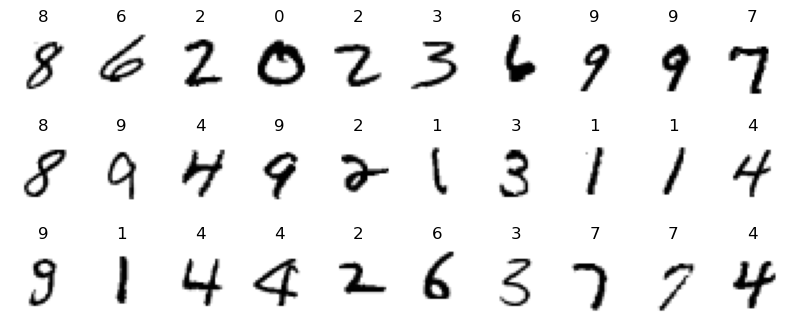

In [12]:
display_images(train_image, train_label, start=20, images_count=30)

[Text(0.5, 1.0, 'Number of images in each class')]

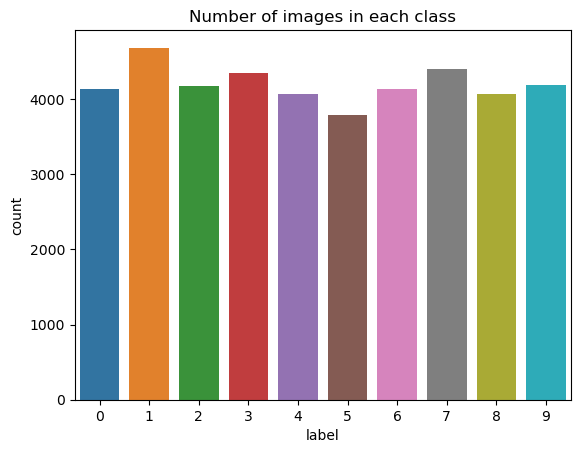

In [13]:
sns.countplot(x='label', data=train_df).set(title='Number of images in each class')

## Preprocessing

## Data Modeling

In [20]:
import tensorflow as tf
from tensorflow.keras.models import save_model, load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical, plot_model

In [21]:
print("TensorFlow version:", tf.__version__)
print("Is Tensorflow buit with CUDA:", tf.test.is_built_with_cuda())

TensorFlow version: 2.9.1
Is Tensorflow buit with CUDA: False


In [43]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation="relu", name="layer1"))
model.add(Dense(10, activation='softmax'))

In [44]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

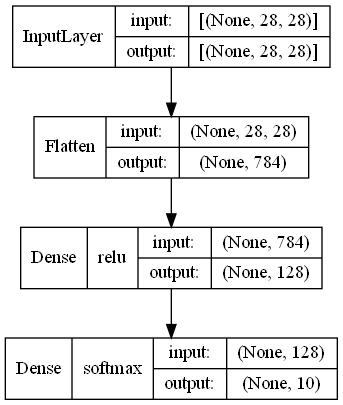

In [51]:
plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=False)

In [53]:
model.fit(x=train_image, y=train_label, epochs=6)

Epoch 1/6
1313/1313 [==============================] - 17s 13ms/step - loss: 0.4457 - sparse_categorical_accuracy: 0.9047
Epoch 2/6
1313/1313 [==============================] - 15s 12ms/step - loss: 0.3203 - sparse_categorical_accuracy: 0.9226
Epoch 3/6
1313/1313 [==============================] - 11s 8ms/step - loss: 0.2620 - sparse_categorical_accuracy: 0.9325
Epoch 4/6
1313/1313 [==============================] - 13s 10ms/step - loss: 0.2365 - sparse_categorical_accuracy: 0.9395
Epoch 5/6
1313/1313 [==============================] - 11s 8ms/step - loss: 0.2109 - sparse_categorical_accuracy: 0.9446
Epoch 6/6
1313/1313 [==============================] - 12s 9ms/step - loss: 0.2084 - sparse_categorical_accuracy: 0.9464


In [32]:
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.build()